In [40]:
from tqdm.autonotebook import tqdm
from keras.callbacks import CSVLogger
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
import itertools
from timeit import default_timer as timer
import keras
import seaborn as sns

# Temperature Forecasting using RNN (with sampled generators)

## 1 Data Preprocessing

### 1.1 Data Extraction

#### Read csv data

In [4]:
data = pd.read_csv('jena_climate_2009_2016.csv')
data.head(5)

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


#### Transform to numpy array

In [5]:
data = data.iloc[:, 1:].astype(float).to_numpy()

#### Normalize

In [6]:
mean = data[:200000].mean(axis=0)
data -= mean
std = data[:200000].std(axis=0)
data /= std

### 1.2 Data Generators

In [141]:
def get_samples(data, indices, step, mode='first'):
    """Return sampled data based on specified mode"""
    # Return the usual way if 'first'
    if mode == 'first':
        return data[indices]
    
    # Split data according to the step size, indices indicate the data range
    split_data = np.array_split(data[indices[0]:indices[-1]+step],
                                indices[1:]-indices[0])

    # Return processed sample based on input
    if mode == 'mean':
        return np.mean(split_data, axis=1)
    elif mode == 'max':
        return np.max(split_data, axis=1)
    elif mode == 'min':
        return np.min(split_data, axis=1)

def generator(data, lookback, delay, min_index, max_index, shuffle=False,
              batch_size=128, step=6, mode='first'):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index,
                                     size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = np.arange(rows[j] - lookback, rows[j], step)
            samples[j] = get_samples(data, indices, step, mode)
            targets[j] = data[rows[j] + delay][1]
            
        yield samples, targets

In [139]:
lookback = 1440
step = 6
delay = 144
batch_size = 128 #Each of the batch will have inputs = lookback/step (240 hours in this example) +  delay/step (24 hours)  

def get_generators(data, lookback, delay, step, batch_size, mode):
    train_gen = generator(data,
                          lookback=lookback,
                          delay=delay,
                          min_index=0,
                          max_index=200000,
                          shuffle=True,
                          step=step,
                          batch_size=batch_size,
                          mode=mode)

    val_gen = generator(data,
                        lookback=lookback,
                        delay=delay,
                        min_index=200001,
                        max_index=300000,
                        step=step,
                        batch_size=batch_size,
                        mode=mode)

    test_gen = generator(data,
                         lookback=lookback,
                         delay=delay,
                         min_index=300001,
                         max_index=None,
                         step=step,
                         batch_size=batch_size,
                         mode=mode)
    
    return train_gen, val_gen, test_gen

## 2 Models and Simulations

### 2.1 Models

In [21]:
def get_model(data, lookback, step, model='dense'):
    # Initialize model
    m = Sequential()
    
    # Add intermediate model
    if model == 'dense':
        m.add(layers.Flatten(input_shape=(lookback//step,
                                              data.shape[-1])))
        m.add(layers.Dense(32, activation='relu'))
    elif model == 'LSTM':
        m.add(layers.LSTM(32, input_shape=(None, data.shape[-1])))
    elif model == 'GRU':
        m.add(layers.GRU(32, input_shape=(None, data.shape[-1])))
        
    # Add dense layer
    m.add(layers.Dense(1))
    
    return m

### 2.2 Simulations

In [24]:
class TimingCallback(keras.callbacks.Callback):
    def __init__(self, filepath, logs={}):
        self.logs=[]
        self.filepath = filepath
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)
        with open(self.filepath, 'a') as f:
            f.write(str(timer()-self.starttime) + '\n')

In [ ]:
# Initialize modes and models
modes = ['first', 'mean', 'min', 'max']
models = ['dense', 'LSTM', 'GRU']

# Iterate through all combinations of mode and models
for mode, m in itertools.product(modes, models):
    # Initialize generators
    train_gen, val_gen, test_gen = get_generators(data, lookback, delay, step,
                                                  batch_size, mode)
    
    # Initialize model
    model = get_model(data, lookback, step, model=m)
    model.compile(optimizer=RMSprop(), loss='mae')
    
    # Initialize logger
    csv_logger = CSVLogger(f'{m}_{mode}.csv', append=True, separator=',')
    time_logger = TimingCallback(f'{m}_{mode}_runtimes.csv')
    
    # Fit model
    history = model.fit(train_gen,
                        steps_per_epoch=500,
                        epochs=10,
                        validation_data=val_gen,
                        validation_steps=1000,
                        callbacks=[csv_logger, time_logger],
                        verbose=0)

## 3 Results

### 3.1 Merge Results

In [109]:
# Set models and modes values
models = ['dense', 'LSTM', 'GRU']
modes = ['first', 'mean', 'min', 'max']

# Initialize merged results container
res = pd.DataFrame(columns={'epoch', 'val_loss', 'mode', 'runtime', 'model'})

# Iterate through all modes and odels
for mode, model in itertools.product(modes, models):
    # Read loss dataframe
    cur_data = pd.read_csv(f'{model}_{mode}.csv')
    
    # Add epoch, model, and mode labels
    cur_data['model'] = model
    cur_data['mode'] = mode.title()
    cur_data['epoch'] = np.arange(1, len(cur_data)+1)
    
    # Add runtime data
    cur_data['runtime'] = pd.read_csv(f'{model}_{mode}_runtimes.csv',
                                      squeeze=True, names=['runtime'])

    res = res.append(cur_data)    

### 3.2 Plot results

In [144]:
def plot_results(res, model, param, ylim=None, legend_loc=None,
                 filepath=None):
    """
    Plot the trend of the model at different modes for the given param
    
    Plots the trend line per epoch and the boxplot for the range of values of
    the specified `param` given the `res` dataframe and the `model` to be
    inspected.
    
    Parameters
    ----------
    res : pandas DataFrame
        Data frame containing the validation loss and run time results
    model : str
        Model to be inspected; can be 'dense', 'LSTM', or 'GRU'
    param : str
        Parameter to be inspected; can be 'val_loss' or 'runtime'
    ylim : tuple, default=None
        Set to specify ylim of the box plot
    legend_loc : tuple, default=None
        Set to specify legend location
        
    Returns
    -------
    fig, ax : matplotlib figure and axes
        Figure and axes of the plots
    """
    # Initialize titles
    titles = {'val_loss': 'Validation loss',
              'runtime': 'Run time'}
    
    # Get current data
    cur_data = res[res.model == model]
    
    # Initialize figure
    if param == 'val_loss':
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    else:
        fig = plt.figure(figsize=(8, 6))
        axes = [fig.add_subplot(111)]
    
    # Plot results
    sns.lineplot(x='epoch', y=param, data=cur_data, hue='mode', ax=axes[0],
                 lw=3.0, marker='o', markeredgecolor=None, alpha=0.85, ms=7,
                 legend=True)
    if param == 'val_loss':
        sns.boxplot(x='mode', y=param, data=cur_data, ax=axes[1])
    
    # Get legend then re-draw
    h, l = axes[0].get_legend_handles_labels()
    axes[0].get_legend().set_visible(False)
    l = axes[0].legend(h, l, fontsize=12, frameon=False,
                       bbox_to_anchor=legend_loc)
    
    # Set axis limits of box plot if specified
    if ylim is not None:
        if param == 'val_loss':
            axes[1].set_ylim(ylim)
    
    # Remove spines and set labels
    for ax in axes:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_ylabel(f'{titles[param].title()}', fontsize=14)
    axes[0].set_xlabel('Epoch', fontsize=14)
    
    if param == 'val_loss':
        axes[1].set_xlabel('Mode', fontsize=14)

    # Set figure title
    fig.suptitle(f"{titles[param]} trend for {model} neural network",
                 fontsize=16, weight='bold')
    
    # Save figure
    plt.savefig(filepath, dpi=150, bbox_inches='tight')
    
    return fig, axes

#### Validation Loss

##### Dense

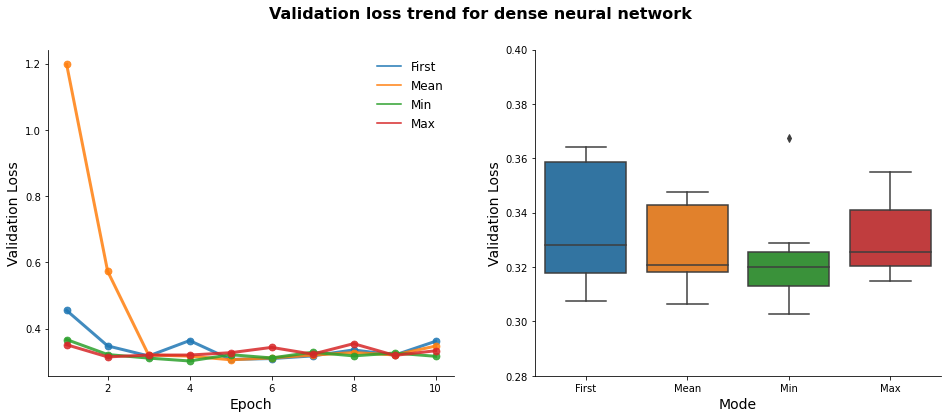

In [145]:
plot_results(res, 'dense', 'val_loss', ylim=(0.28, 0.40),
             filepath='dense_loss.png');

##### LSTM

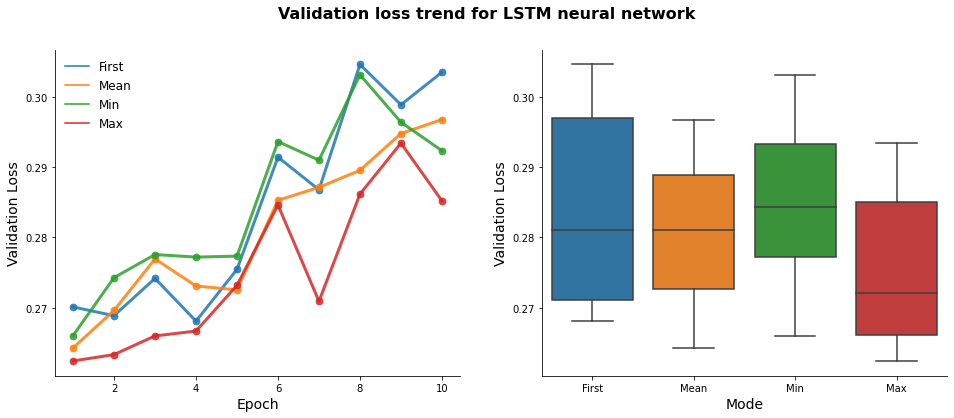

In [146]:
plot_results(res, 'LSTM', 'val_loss', ylim=None, filepath='lstm_loss.png');

##### GRU

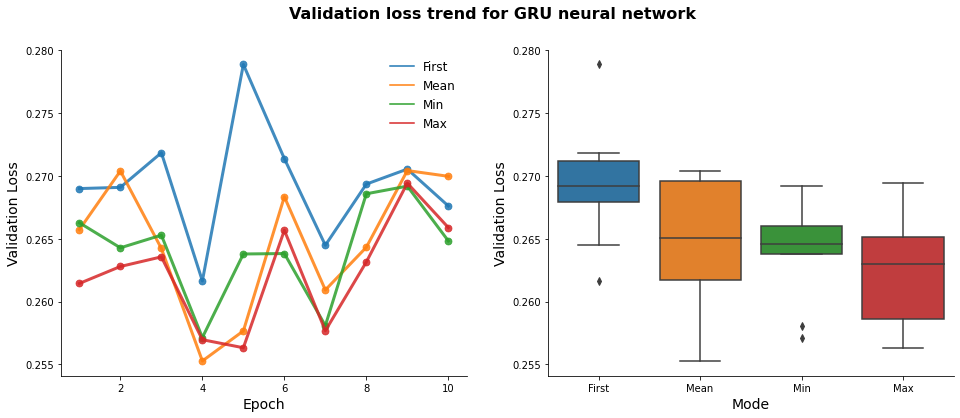

In [147]:
plot_results(res, 'GRU', 'val_loss', ylim=None, filepath='gru_loss.png');

#### Run time

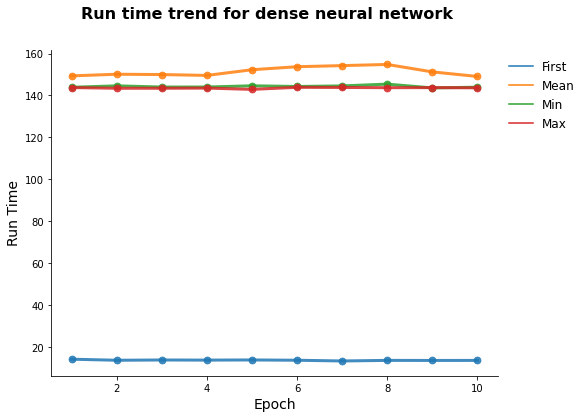

In [148]:
plot_results(res, 'dense', 'runtime', legend_loc=(1.0, 1.0),
             filepath='dense_runtime.png');

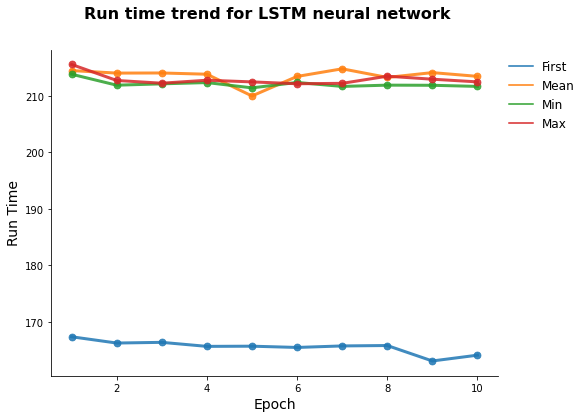

In [150]:
plot_results(res, 'LSTM', 'runtime', legend_loc=(1.0, 1.0),
             filepath='lstm_runtime.png');

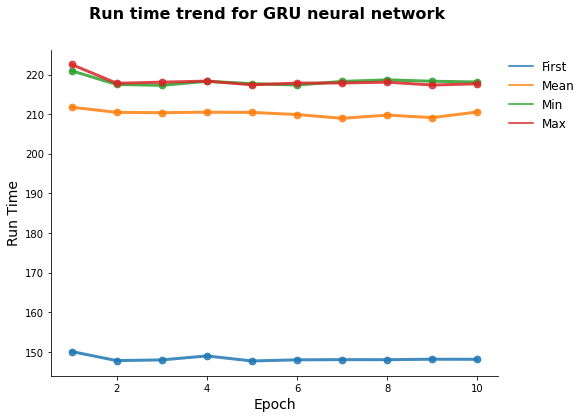

In [151]:
plot_results(res, 'GRU', 'runtime', legend_loc=(1.0, 1.0),
             filepath='gru_runtime.png');

## 4 Key Takeaways

1. Deepen our understanding of how the data is restructured in preparation for the input in the neural network models.
2. Sampling aggregation operations such as `mean`, `max`, or `min` have marginal gains in the accuracy specially for the NN with a recurrent architecture. In particular, up to 0.005 to 0.006 added decrease in MAE validation loss can be achieved by properly choosing which aggregation operation to use. Translating to up to a 0.53 °C decrease in average absolute error. This increase in accuracy for the RNN models may be attributed to the robust handling of these aggregation operations to fluctuations in the data.
3. This however, comes at computational cost. In our algorithm, additional 50~70 secs was needed per epoch to add the aggregation operation for the RNN models (see Tables below for reference). Our estimation is that this computional cost will increase linearly according to the data size. Hence, for practicality, our general advice is to first perform model fitting at the default setting. Then for fine-tuning, we can explore which sampling aggregation operation to use to further increase the accuracy.

#### Validation Loss

In [132]:
res.groupby(['model', 'mode'])[['val_loss', 'runtime']].min()

val_loss     runtime
model mode                       
GRU   First  0.261649  147.684520
      Max    0.256330  217.339300
      Mean   0.255277  208.935512
      Min    0.257142  217.272816
LSTM  First  0.268089  163.075777
      Max    0.262423  212.177032
      Mean   0.264278  210.011653
      Min    0.266022  211.446436
dense First  0.307381   13.228139
      Max    0.314974  142.917572
      Mean   0.306266  149.085038
      Min    0.302685  143.622873

In [171]:
val_loss_gain = ((res.loc[res['mode'] != 'First']
                     .groupby('model')
                     .val_loss
                     .min() 
                 - res.loc[res['mode'] == 'First']
                      .groupby('model')
                      .val_loss
                      .min()).reset_index())
val_loss_gain['abs_error'] = val_loss_gain.val_loss * std[1]
val_loss_gain

,model,val_loss,abs_error
0,GRU,-0.006372,-0.056407
1,LSTM,-0.005667,-0.050164
2,dense,-0.004696,-0.041571


#### Runtime

In [166]:
((res.loc[res['mode'] != 'First']
     .groupby('model')
     .runtime
     .mean() 
 - res.loc[res['mode'] == 'First']
      .groupby('model')
      .runtime
      .mean()).reset_index())

,model,runtime
0,GRU,67.294427
1,LSTM,47.329532
2,dense,132.857087
